\tableofcontents

# Executive Summary


This project investigates the feasibility of developing a machine learning model that can distinguish between images of smiling and non-smiling individuals. A dataset of 208 images was collected, evenly split between the two categories. The images were preprocessed using Haar Cascade classifiers for face detection, converted to grayscale, resized to 64x64 pixels, and normalized to enhance model performance. Logistic Regression and Convolutional Neural Network (CNN) models were implemented. Logistic Regression achieved an accuracy of 83% but exhibited signs of overfitting, which was mitigated by applying Principal Component Analysis (PCA) for dimensionality reduction. The CNN also reached 83% accuracy without overfitting, while combining PCA with CNN decreased performance. The findings suggest that PCA benefits simpler models like Logistic Regression, whereas CNNs perform better with raw image data.


# Introduction

## Background

Tired of job searches during my freshman summer, I took a photography role at a summer camp. It required me to buy a mirrorless camera that took good portrait pictures. Every day, I had to take 1,000 pictures, go through them, pick the best ones, edit them, and upload only 200 of the best onto the camp portal for parents to see. I quickly realized I had to take multiple pictures of the same scene to have a backup in case something was blurry or someone's eyes were closed.

I found that I enjoyed my summer job so much that I wanted to pursue it beyond just that summer and become better at photography. To improve, I needed to practice portrait photography. That’s when I sent this message in our class group chat in the fall of 2022:

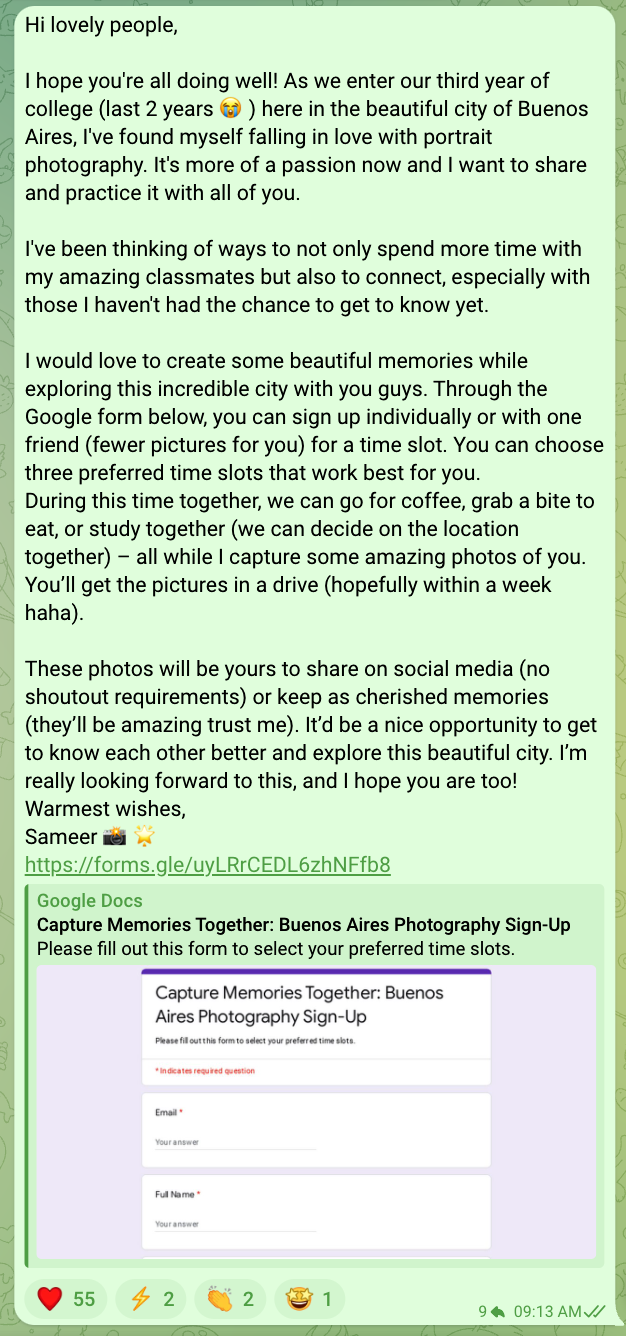

## Context

The tricky part of the job wasn’t taking a thousand pictures a day; the tricky part was selecting the best-looking ones. At the summer camp and even when doing photoshoots with my friends, I always struggled to choose between images that had no errors. When there was no blurriness, stillness, and perfect focus, how do I decide which to keep and which to delete?

I began researching the subject and revisiting my summer archives. I realized I generally favor pictures where my subject is smiling or laughing, especially when their teeth are visible (given no other errors). [This](https://cyme.io/the-smile-in-pictures-the-kingdom-of-narcisse/#:~:text=How%20did%20the%20smile%20become,ones%2C%20implicit%20and%20ambiguous%20ones%E2%80%A6) article states, "The smile has become necessary to show good health, prosperity, and the joy of living."

I had an epiphany at that moment: if a smile is the deciding factor between two pictures where all other factors are equal, I would love for a model to exist that could sift through an album and automatically segregate smiling and non-smiling pictures. Therefore, I want this project to detect people's smiles in pictures and categorize them into smiling and not-smiling.




## Exploratory Question

"*Is it feasible to develop a machine learning model that accurately differentiates between an image in which the subject is smiling from those in which the subject is not smiling?* **For a subject to be considered smiling, they needed to have their mouth open with at least some teeth visible**"




## Data Collection
To train the model, I reached out to 12 friends with whom I had previously done photoshoots, ensuring an equal male-to-female ratio. Each of them allowed me to use their photos for this project. I selected a total of 208 images—104 pictures where people were smiling and 104 where they were not, and placed them in separate folders named "Smiling" and "Not_smiling" respectively. This balance was intentional to prevent class imbalance, which could skew the model's predictions in favor of one category over the other.

All images were portrait-style, captured from a frontal angle, with no extreme poses or unusual angles. I carefully curated the dataset to include only photos with a single subject per image, ensuring a clear distinction between the foreground and background. While all the photos were taken during daylight hours, I included only well-lit images to maintain consistency in lighting conditions.

Additionally, I allowed for the presence of accessories like jewelry, sunglasses and headscarves to add variety and realism. The images were in color, and I intentionally selected individuals from different ethnographic backgrounds to ensure diversity in the dataset. This approach aimed to reduce potential biases in the model's training, ensuring it could generalize across various demographics and cultural contexts.

## Sampling
To ensure a robust model, I paid particular attention to how I defined smiling and non-smiling images. **For a subject to be considered smiling, they needed to have their mouth open with at least some teeth visible**. However, I also included edge cases in the non-smiling category, where subjects had their teeth visible, but were not necessarily smiling or laughing. These instances occurred because the subjects were talking, in shock, or expressing some other emotion that involved visible teeth but did not convey happiness.

This approach will potentially allow the model to differentiate between genuine smiles and other expressions that involve visible teeth, thereby refining the model’s ability to focus on the full context of a smile. With this approach, I aimed to prevent the model from overfitting to the simplistic rule of "visible teeth = smiling," which would reduce its accuracy in real-world applications.

# Data Processing and Feature Engineering

## Data Processing

Below, we start by establishing separate directories for pre-processed and processed images to maintain the integrity of our original dataset while allowing for manipulation of the processed data.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from joblib import dump
from sklearn.base import clone
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Paths to the directories containing images
preprocessed_dirs = {
    'Smiling': '/content/drive/MyDrive/Photography/CS156 first pipeline/Pre-processed/Smiling',
    'Not Smiling': '/content/drive/MyDrive/Photography/CS156 first pipeline/Pre-processed/Not_smiling'
}

processed_dirs = {
    'Smiling': '/content/drive/MyDrive/Photography/CS156 first pipeline/Processed/Smiling',
    'Not Smiling': '/content/drive/MyDrive/Photography/CS156 first pipeline/Processed/Not_smiling'
}

# Create output directories if they don't exist
for dir_path in processed_dirs.values():
    os.makedirs(dir_path, exist_ok=True)



The core of our image processing revolves around face detection, for which we've chosen to use the [**Haar Cascade classifier**](https://medium.com/analytics-vidhya/haar-cascades-explained-38210e57970d). Haar Cascade, while an older technique, is computationally efficient and sufficiently accurate for our needs. It allows us to quickly identify faces within images without requiring the computational overhead of more complex deep learning-based face detection methods. It works by utilizing pre-trained binary patterns correlating to human facial features to identify and isolate faces. Part of the reason to choose Haar Cascades is driven by their speed and reliability for processing static images where real-time detection is unnecessary. Moreover, it is easily integrable with OpenCV and effectiveness across a broad range of lighting conditions and face orientations make them ideal for preliminary face detection tasks.

After detecting faces in the images, we proceed to crop and resize them to a uniform dimension of 64x64 pixels. This step ensures that:

1. All input data fed into our machine learning model shares the same dimensions so that the model can process the data in a unifrom manner.

2. The choice of 64x64 pixels is a balance between retaining sufficient facial details for accurate classification and maintaining manageable computational requirements. While larger images might offer more detail, they would also increase processing time and memory usage. By standardizing the image size, we enable the model to focus on the essential facial features without being influenced by redundant background elements.

We also convert all images to the JPEG format. This decision is motivated by JPEG's widespread compatibility and its [**compression algorithm**](https://www.baeldung.com/cs/jpeg-compression#:~:text=JPEG%20stands%20for%20Joint%20Photographic,smaller%20than%20the%20original%20one.), which preserves image quality while reducing file sizes. Smaller file sizes lead to faster loading times and decreased storage needs—beneficial factors when handling large datasets.

In terms of color processing, we've opted to convert all images to grayscale. Although color information can sometimes aid in smile detection, grayscale images are typically [sufficient](https://www.researchgate.net/publication/11140203_Contribution_of_Color_to_Face_Recognition) for facial expression recognition tasks. By reducing each image to a single color channel, we simplify the data without significantly losing the features necessary for accurate smile detection. This simplification can also help reduce noise and emphasize the most relevant structural features of the face.

In [2]:
def process_and_save_images(input_folder, output_folder):
    """
    Processes images from the input_folder by detecting faces, extracting the face region,
    resizing to 64x64 pixels, and saving the processed grayscale images to the output_folder.

    Parameters:
        input_folder (str): Path to the folder containing input images.
        output_folder (str): Path to the folder where processed images will be saved.
    """
    # Initializing face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        # Converting filename to .jpg extension
        new_filename = os.path.splitext(filename)[0] + '.jpg'
        output_path = os.path.join(output_folder, new_filename)

        try:
            # Reading the image
            img = cv2.imread(input_path)
            if img is None:
                print(f"This is not a picture '{input_path}'")
                continue
            # Converting to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Detecting faces in the image
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
            if len(faces) > 0:
                # If faces are detected, extract the first face
                x, y, w, h = faces[0]
                face = gray[y:y+h, x:x+w]
                # Resize the face region to 64x64 pixels
                face_resized = cv2.resize(face, (64, 64))
                # Save the processed image
                cv2.imwrite(output_path, face_resized)
            else:
                print(f"No face detected in '{input_path}'")
        except Exception as e:
            print(f"Error processing image '{input_path}': {e}")


## Feature Extraction and Data Normalization

For feature extraction process, we utilize OpenCV to handle image processing tasks. By reading and manipulating images as NumPy arrays, we prepare the data in a format that's usable by our machine learning model ([Noble, 2023](https://www.tecton.ai/blog/introducing-array-type-features/)). After OpenCV's Haar Cascade Classifier isolates the face region, we move on to resizing and normalizing the images.

We normalize our pixel values by scaling them from the standard 0-255 range to floating-point values between 0 and 1 which brings all features to a common scale, enhancing the performance and convergence speed of our learning algorithm. It also mitigates potential numerical instability issues that can arise during certain computations in machine learning models.

Our choice of preprocessing pipeline is setting a solid foundation for integrating with machine learning frameworks such as Keras or TensorFlow in the future. Our approach provides the flexibility to expand our project and explore more advanced model architectures as needed.

Below, we output a small sample from out preprocessed data from both the smiling and not-smiling folders.

This is not a picture '/content/drive/MyDrive/Photography/CS156 first pipeline/Pre-processed/Smiling/.DS_Store'
This is not a picture '/content/drive/MyDrive/Photography/CS156 first pipeline/Pre-processed/Not_smiling/.DS_Store'


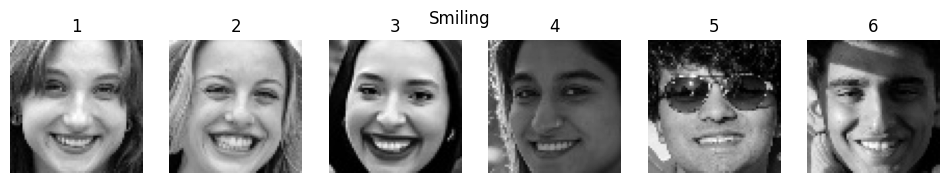

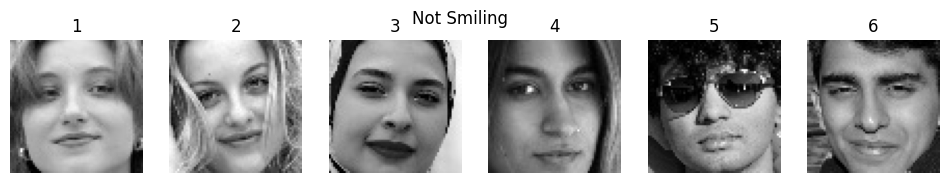

In [3]:
def display_images(processed_folder_smiling, processed_folder_not_smiling):
    """
    Displays sample images from the processed folders for 'Smiling' and 'Not Smiling' categories.

    Parameters:
        processed_folder_smiling (str): Path to the folder containing processed 'Smiling' images.
        processed_folder_not_smiling (str): Path to the folder containing processed 'Not Smiling' images.
    """
    categories = {'Smiling': processed_folder_smiling, 'Not Smiling': processed_folder_not_smiling}
    # List of image filenames (without extension) to display
    images_to_display = ['1', '2', '3', '4', '5', '6']

    for category_name, folder in categories.items():
        images_list, filenames_list = [], []
        for img_name in images_to_display:
            img_path = os.path.join(folder, f'{img_name}.jpg')
            if os.path.isfile(img_path):
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images_list.append(img)
                    filenames_list.append(img_name)
                else:
                    print(f"Image '{img_path}' could not be read.")
            else:
                print(f"Image '{img_path}' does not exist.")

        if images_list:
            # Creating a figure with subplots
            fig, axes = plt.subplots(1, len(images_list), figsize=(len(images_list) * 2, 2))
            fig.suptitle(category_name)
            for i, ax in enumerate(axes):
                # Displaying each image
                ax.imshow(images_list[i], cmap='gray')
                ax.axis('off')
                ax.set_title(filenames_list[i])
            plt.show()
        else:
            print(f"No images to display for category '{category_name}'.")

# Process and save images for both categories
for category, dirs in preprocessed_dirs.items():
    process_and_save_images(dirs, processed_dirs[category])

# Displaying the first few images
display_images(processed_dirs['Smiling'], processed_dirs['Not Smiling'])


## Loading and Normalizing the Images into Arrays

After processing and standardizing our images, the next step is to load them into a format suitable for input into our machine learning model. We achieve this through the function "load_images_to_array", which systematically reads each processed image, normalizes it, and appends it to our data structures for features and labels. As we process each image, we append it to the data list and simultaneously append the corresponding label (1 for smiling, 0 for not smiling) to the labels list.

By organizing our data this way, we create NumPy arrays that hold our image data and labels which is compatible with machine learning frameworks and our models.

In [4]:
# Code Cell 4: Load and Normalize Images

# Define the image size (width, height)
image_size = (64, 64)

# Initialize lists to hold images and labels
data = []
labels = []

def load_images_to_array(folder, label):
    """
    Loads images from the specified folder, normalizes them, and appends them to the data list along with their labels.

    Parameters:
        folder (str): Path to the folder containing images to load.
        label (int): Label associated with the images in this folder (e.g., 1 for 'Smiling', 0 for 'Not Smiling').
    """
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        # Reading image in grayscale
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            # Normalizing the image
            image = image.astype('float32') / 255.0
            # Appending image and label to lists
            data.append(image)
            labels.append(label)
        else:
            print(f"Image '{img_path}' could not be loaded.")

# Loading images and labels for both categories
for category, dirs in processed_dirs.items():
    label = 1 if category == 'Smiling' else 0
    load_images_to_array(dirs, label)


## How do we Normalize?

Let:
- $I$ be the original grayscale image matrix with pixel values $I_{i,j} \in \{0,1,2,\ldots,255\}$, where $i$ and $j$ index the rows and columns of the 64x64 image, respectively.
- $I'$ be the normalized image matrix with pixel values $I'_{i,j}$

### Normalization Operation

$$
I'_{i,j} = \frac{I_{i,j}}{255.0}
$$


This formula is applied element-wise to every pixel in the 64x64 image, and it maps the original pixel values from integer range [0, 255] to floating-point range [0.0, 1.0]. This results in the following Pixel Values:

- For a pixel with minimum intensity (black):
$$
\text{If } I_{i,j} = 0, \text{ then } I'_{i,j} = \frac{0}{255.0} = 0.0
$$

- For a pixel with maximum intensity (white):
$$
\text{If } I_{i,j} = 255, \text{ then } I'_{i,j} = \frac{255}{255.0} = 1.0
$$

- For a pixel with intermediate intensity:
$$
\text{If } I_{i,j} = k, \text{ then } I'_{i,j} = \frac{k}{255.0}, \text{ where } 0 < k < 255
$$

By specifying dtype='float32', we ensure that the data is in a format that's compatible with most machine learning frameworks, which often expect 32-bit floating-point numbers for input data.

Next, we reshape the data array to include a channel dimension. Although our images are grayscale (having only one channel), many machine learning models, particularly convolutional neural networks (CNNs), expect input data to have a shape that includes the number of channels.

In [5]:
# Converting the data and labels to NumPy arrays
data = np.array(data, dtype='float32')
labels = np.array(labels)

# Reshaping data to include channel dimension (for grayscale images, it's 1 channel)
data = data.reshape(-1, image_size[0], image_size[1], 1)

# Output the shapes of the datasets
print(f'Total images: {data.shape[0]}')
print(f'Data shape: {data.shape}')
print(f'Labels shape: {labels.shape}')


Total images: 208
Data shape: (208, 64, 64, 1)
Labels shape: (208,)


## Descriptive Stats



Total number of samples: 208
Class distribution:
  Not Smiling: 104 samples
  Smiling: 104 samples
Pixel value statistics:
  Mean: 0.49702519178390503
  Standard Deviation: 0.17813602089881897
  Min: 0.0
  Max: 1.0


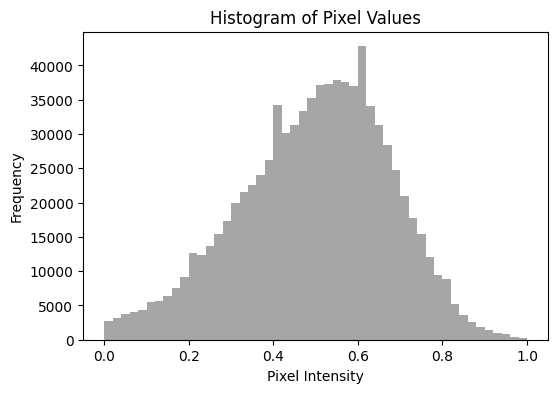

Image dimensions: (64, 64, 1)
Number of missing or corrupted images: 0

Pixel value statistics for "Not Smiling":
  Mean: 0.4854
  Standard Deviation: 0.1787

Pixel value statistics for "Smiling":
  Mean: 0.5087
  Standard Deviation: 0.1768


In [6]:
# Descriptive Statistics and Visualization

# Number of samples and class distribution
total_samples = data.shape[0]
print(f'Total number of samples: {total_samples}')

unique_labels, counts = np.unique(labels, return_counts=True)
class_distribution = dict(zip(unique_labels, counts))
print('Class distribution:')
for label, count in class_distribution.items():
    label_name = 'Smiling' if label == 1 else 'Not Smiling'
    print(f'  {label_name}: {count} samples')

# Descriptive statistics for all data
pixel_values = data.flatten()
stats = {
    'Mean': np.mean(pixel_values),
    'Standard Deviation': np.std(pixel_values),
    'Min': np.min(pixel_values),
    'Max': np.max(pixel_values)
}
print('Pixel value statistics:')
for key, value in stats.items():
    print(f'  {key}: {value:.4f}' if isinstance(value, float) else f'  {key}: {value}')

# Plotting histogram of pixel values
plt.figure(figsize=(6,4))
plt.hist(pixel_values, bins=50, color='gray', alpha=0.7)
plt.title('Histogram of Pixel Values')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

# Image dimensions
print(f'Image dimensions: {data.shape[1:]}')

# Checking for missing or corrupted images
expected_images = class_distribution.get(0, 0) + class_distribution.get(1, 0)
missing_images = total_samples - expected_images
print(f'Number of missing or corrupted images: {missing_images}')

# Descriptive statistics per class
for cls in [0, 1]:
    label_name = 'Smiling' if cls == 1 else 'Not Smiling'
    class_pixels = data[labels == cls].flatten()
    class_stats = {
        'Mean': np.mean(class_pixels),
        'Standard Deviation': np.std(class_pixels)
    }
    print(f'\nPixel value statistics for "{label_name}":')
    for key, value in class_stats.items():
        print(f'  {key}: {value:.4f}')

The pixel value distribution shows a near-symmetric, bell-shaped curve, which closely resembles a normal distribution, centered around the mean of 0.497. Most pixel values in the dataset are clustered around this middle range, with fewer pixels having extremely low or high intensities. The normalization of the pixel values to fall between 0 and 1 ensures that no single pixel dominates the model's learning process, contributing to more stable training.

The difference between the "Not Smiling" and "Smiling" images, where the means are 0.4854 and 0.5087 respectively, indicates that smiling faces tend to have slightly higher overall pixel brightness. This could reflect the lighter regions in smiling faces, such as exposed teeth or the creases around the mouth and eyes. The standard deviations for both classes are very close, indicating consistent variability in pixel values, meaning the intensity spread is similar across both smiling and non-smiling images.

Our dataset's near-normal distribution implies that it contains a good variety of pixel intensities without extreme outliers, which should help the model generalize better by focusing on the subtle variations between smiling and not smiling faces rather than being influenced by extreme pixel values.

# Task Discussion

Our objective is to differentiate between images of smiling faces and not smiling faces, framing our task as a binary classification problem. We focus on processing facial images to extract meaningful features that can help a machine learning model distinguish between these two expressions. Our preprocessing steps: detecting faces within the images and cropping, converting them to grayscale, resizing them to a uniform dimension of 64x64 pixels, standardizing the data, and ensuring consistency across all input samples, have reduced the computational complexity. Now our model can learn patterns associated with smiling and non-smiling expressions effectively.

## Data Splitting

Firstly, we flatten each 64x64 pixel image into a one-dimensional array of 4096 elements (since 64×64=4,096) which converts our data from a multi-dimensional array to a two-dimensional array where each row represents a flattened image, and each column represents a pixel value.

To prepare our data for training and evaluation, we utilize the train_test_split function from scikit-learn, which helps us divide our dataset in a systematic and reproducible manner. We allocate 80% of the data to the training set and the remaining 20% to the testing set. This 80/20 split will balance the need for ample training data and a substantial amount of test data to evaluate our model's performance on unseen images.

We will also stratify our labels to ensure that the proportion of smiling and not smiling images is maintained in both the training and testing sets. This is an important step which will prevent class imbalance, which could bias the model towards the majority class.

In [7]:
# Split the data into training and testing sets (80% training, 20% testing) with shuffling
X_train, X_test, y_train, y_test = train_test_split(
    data.reshape(data.shape[0], -1), labels, test_size=0.20, stratify=labels, random_state=42
)

print(f'Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}')

Training samples: 166, Testing samples: 42


# Model Selection

When it comes to choosing a model for project, we want to start simple and add complexity as we progress. With this approach we can implement models that are easier to understand and interpret, and we can implement them right from the beginning. This will help us quickly establish a baseline performance. If our initial simple model shows signs of underfitting—meaning it's too basic to capture the underlying patterns in our data—we might consider moving to a more complex model that can learn these patterns better. On the other hand, if our model starts overfitting, capturing too much noise and displaying high variance, we might need to simplify our approach to prevent overfitting.

## Logistic Regression

Logistic Regression in scikit-learn, despite its name, functions as a linear classification model rather than a regression model. It uses a logistic function to model the probabilities of different outcomes for a given trial, which makes it well-suited for tasks like binary classification, One-vs-Rest schemes, or multinomial logistic regression, with the option to include regularization.

## Why Logistic Regression?

Logistic regression is inherently designed for binary classification tasks, making it a natural choice for our problem where the output is either 'Smiling' (1) or 'Not Smiling' (0). It is a straightforward algorithm that doesn't require extensive computational resources, and its interpretability allows us to understand how the model makes predictions based on input features.

Furthermore, starting with logistic regression provides us with a a baseline performance metric. It will help us in gauging the effectiveness of our preprocessing steps and the separability of our data before considering more complex models. Lastly, with our dataset of 208 images, logistic regression can be trained quickly. This way, we also adhere to the principle of [Occam's Razor](https://pmc.ncbi.nlm.nih.gov/articles/PMC9882019/#:~:text=Occam's%20razor%20is%20the%20principle,for%20simplicity%20is%20not%20understood.)—preferring the simplest model that adequately fits the data before moving on to more complex alternatives if necessary.

## How Logistic Regression Works
Logistic regression models the probability that a given input belongs to a particular class. In our context, it estimates the probability that a facial image depicts a smiling person.

At its core, logistic regression takes the linear combination of input features and applies a logistic function (also known as the sigmoid function) to map any real-valued number into a probability between 0 and 1.

For each input image represented by a feature vector $x_i$, the model computes a weighted sum (also called the logit):

$$
z_i = w^\top x_i + b
$$


Where:
- $w$ is the weight vector (parameters) associated with the features.
- $b$ is the bias term.
- $z_i$ is the linear combination result for the $i$-th example.

This result is then passed through the logistic function to obtain the predicted probability $p_i$:

$$
p_i = \sigma(z_i) = \frac{1}{1 + e^{-z_i}}
$$


The logistic function $\sigma(z)$ squeezes the input $z$ into the range (0, 1), making it suitable to represent a probability.

The model predicts the class label $\hat{y}_i$ based on whether $p_i$ crosses a certain threshold (commonly 0.5):

$$
\hat{y}_i = \left\{
\begin{array}{ll}
1 & \text{if } p_i \geq 0.5 \\
0 & \text{if } p_i < 0.5
\end{array}
\right\}
$$

## Mathematical Formulation

### Model Representation

Given:
- A dataset of $m$ training examples $\{(x_i, y_i)\}_{i=1}^m$, where $x_i \in R^n$ is the flattened pixel values of the $i$-th image, and $y_i \in \{0,1\}$ is the corresponding label.

The logistic regression model computes:

$$
z_i = w^\top x_i + b
$$


$$
p_i = P(y_i = 1|x_i) = \sigma(z_i) = \frac{1}{1 + e^{-z_i}}
$$


### Decision Boundary

The decision boundary is determined by the equation $z_i = 0$, which corresponds to $p_i = 0.5$. This hyperplane separates the feature space into two regions:

- If $z_i \geq 0$, then $p_i \geq 0.5$ and the model predicts $\hat{y}_i = 1$ ('Smiling').
- If $z_i < 0$, then $p_i < 0.5$ and the model predicts $\hat{y}_i = 0$ ('Not Smiling').

### Interpretation of Parameters

- Each element $w_j$ of the weight vector $w$ represents the influence of the $j$-th pixel (feature) on the probability of the image being classified as 'Smiling'.
- A positive $w_j$ means that higher pixel values at position $j$ increase the likelihood of the 'Smiling' class.
- A negative $w_j$ indicates the opposite.

However, due to the high dimensionality and nature of image data, individual weights may not provide meaningful insights. The overall pattern of weights contributes to the decision-making process.

## Cost Function
To estimate the optimal parameters $w$ and $b$, we define a cost function that quantifies the difference between the predicted probabilities and actual labels.

### Logistic Loss Function

The logistic regression cost function for a single training example is given by the binary cross-entropy loss:

$$
L(y_i, p_i) = -[y_i \log(p_i) + (1-y_i)\log(1-p_i)]
$$


For the entire training set, the cost function $J(w,b)$ is the average loss over all examples:

$$
J(w,b) = \frac{1}{m}\sum_{i=1}^m L(y_i, p_i) = -\frac{1}{m}\sum_{i=1}^m[y_i\log(p_i) + (1-y_i)\log(1-p_i)]
$$


### Rationale Behind the Cost Function

- The logistic loss function is convex with respect to $w$ and $b$, ensuring that optimization algorithms can find the global minimum.
- Predictions that are confident but incorrect (e.g., $p_i$ close to 1 when $y_i = 0$) incur a high loss, incentivizing the model to adjust parameters to reduce such errors.

### Regularization

Given the high dimensionality of image data, overfitting is a significant concern. Regularization adds a penalty term to the cost function to discourage complex models with large weights.

L2 Regularization (Ridge Regression):

$$
J_{reg}(w,b) = J(w,b) + \frac{\lambda}{2m}\sum_{j=1}^n w_j^2
$$


L1 Regularization (Lasso Regression):

$$
J_{reg}(w,b) = J(w,b) + \frac{\lambda}{m}\sum_{j=1}^n |w_j|
$$


Where:
- $\lambda$ is the regularization parameter controlling the trade-off between fitting data and keeping model weights small.

Regularization helps in:
- Preventing overfitting by penalizing large weights.
- Encouraging simpler models that generalize better to unseen data.

### Optimization

The objective is to find $w$ and $b$ that minimize $J_{reg}(w,b)$. This is typically achieved using optimization algorithms such as:

- Gradient Descent: Iteratively updating parameters in direction opposite to gradient of cost function.

  Update rules:

$$
w_j := w_j - \alpha\frac{\partial J_{reg}}{\partial w_j}
$$


$$
b := b - \alpha\frac{\partial J_{reg}}{\partial b}
$$


Where $\alpha$ is learning rate.

- Advanced Optimization Methods: Algorithms like Limited-memory Broyden–Fletcher–Goldfarb–Shanno (L-BFGS) or stochastic gradient descent variants can be used for faster convergence.

### Gradient Computation

The gradients of cost function with respect to weights and bias are computed as:

Gradient w.r.t $w_j$:

$$
\frac{\partial J_{reg}}{\partial w_j} = \frac{1}{m}\sum_{i=1}^m(p_i - y_i)x_{ij} + \frac{\lambda}{m}w_j
$$


Gradient w.r.t $b$:

$$
\frac{\partial J_{reg}}{\partial b} = \frac{1}{m}\sum_{i=1}^m(p_i - y_i)
$$


These gradients are used to update parameters during optimization.

In [8]:
# Initializing the logistic regression model with L2 regularization
model = LogisticRegression(
    penalty='l2',      # L2 regularization to prevent overfitting
    C=1.0,             # Inverse of regularization strength; smaller values specify stronger regularization
    max_iter=1000,     # Maximum number of iterations for the solver to converge
    random_state=42    # Ensures reproducibility of results
)

# Training the model on the training data
model.fit(X_train, y_train)

# Confirm that training has been completed
print("Model Training Completed.")



Model Training Completed.


# Logistic Regression Evaluation

Classification Report:
              precision    recall  f1-score   support

 Not Smiling       0.82      0.86      0.84        21
     Smiling       0.85      0.81      0.83        21

    accuracy                           0.83        42
   macro avg       0.83      0.83      0.83        42
weighted avg       0.83      0.83      0.83        42



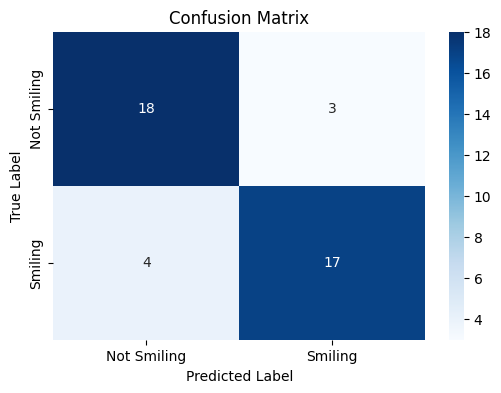

Accuracy: 0.83
Precision: 0.85
Recall: 0.81
F1 Score: 0.83


In [9]:
# Generating predictions on the test data
y_pred = model.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Smiling', 'Smiling']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Not Smiling', 'Smiling'],
    yticklabels=['Not Smiling', 'Smiling']
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Additional performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


## Classification Report and Confusion Matrix

From the output of the model and the confusion matrix, we can draw several conclusions about its performance in classifying smiling and not smiling faces.

- Precision:
  - For the "Not Smiling" class, the precision is 0.82, meaning that 82% of the instances predicted as "Not Smiling" were correct.
  - For the "Smiling" class, the precision is slightly higher at 0.85, indicating that 85% of the predictions labeled as "Smiling" were accurate.

- Recall:
  - The recall for "Not Smiling" is 0.86, which demonstrates that the model correctly identified 86% of all actual "Not Smiling" instances.
  - For the "Smiling" class, the recall is 0.81, meaning it captured 81% of the true "Smiling" instances.

- F1-Score:
  - The F1-scores are quite balanced across both classes, with 0.84 for "Not Smiling" and 0.83 for "Smiling." This suggests that the model strikes a good balance between precision and recall, indicating stable performance across both classes.

- Confusion Matrix:

  - The model correctly predicted "Not Smiling" for 18 out of 21 instances, with only 3 false positives where "Smiling" was incorrectly predicted.
  - For "Smiling" instances, the model made 17 correct predictions but misclassified 4 as "Not Smiling."
  - This indicates that while the model is generally effective, it has slightly more difficulty identifying "Smiling" faces, as reflected by the lower recall for that class. However, the confusion matrix shows that the model is fairly well-balanced in handling both categories, with no significant bias towards either class.

- Performance Observations:
  - Although the accuracy (0.83) and F1-scores indicate a good performance overall, a few points are worth considering:
    - Class Balance: The dataset appears balanced (21 instances for both "Smiling" and "Not Smiling"), which means class imbalance does not appear to be a factor influencing the model’s precision and recall.
    - While the model performs well overall, the slightly lower recall for the "Smiling" class suggests room does leave room for improvement in how the model handles these instances. Maybe, the use of a more sophisticated model might help the model better capture the nuances of smiling features.

- Overfitting or Data Issues:
  - Although the metrics do not show signs of overfitting, as the precision and recall are not overly high or mismatched,I am still a bit skeptical which is why We will now perform Cross-Validation.

## Cross Validation

To ensure that our logistic regression model reliably generalizes to new, unseen data, we will now employ cross-validation techniques in addition to our initial train-test split. Cross-validation involves dividing the dataset into multiple subsets or "folds" and systematically training and validating the model on different combinations of these folds. Specifically, we will use 5-fold cross-validation, where the data is split into five parts, and the model is trained on four folds while validated on the remaining fold. This process is repeated five times, with each fold serving as the validation set once.


In [10]:
# Defining the scoring metrics for evaluation
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Performing 5-Fold Cross-Validation for each metric
for metric in scoring_metrics:
    # Cloning the existing model to ensure a fresh instance for each fold
    cloned_model = clone(model)

    # Computing cross-validation scores
    cv_scores = cross_val_score(
        cloned_model,
        X_train,
        y_train,
        cv=5,
        scoring=metric,
        n_jobs=-1
    )

    # Printing the average score and the confidence interval
    print(f"Average 5-Fold CV {metric.capitalize()}: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

Average 5-Fold CV Accuracy: 0.76 (+/- 0.17)
Average 5-Fold CV Precision: 0.79 (+/- 0.23)
Average 5-Fold CV Recall: 0.75 (+/- 0.08)
Average 5-Fold CV F1: 0.77 (+/- 0.12)
Average 5-Fold CV Roc_auc: 0.84 (+/- 0.15)


The cross-validation outcomes have an average accuracy of 0.76 and a ROC-AUC of 0.84. The model demonstrates a good ability to distinguish between the two classes of smiling and not-smiling. The ROC-AUC score signifies that the model is able differentiate between smiling and non-smiling faces across various threshold settings, which is encouraging for its discriminative capabilities.

Also, the precision and recall metrics are relatively balanced, averaging 0.78 and 0.75 respectively. From this balance we get the sense that the model maintains a fair trade-off between correctly identifying positive instances (smiling faces) and minimizing false positives. Finally, the F1-score of 0.76 further corroborates this balance, suggesting that the model is consistently performing well in terms of both precision and recall.

However, despite these positive indicators, some aspects of the cross-validation results warrant a degree of skepticism. For example, the precision metric exhibits a high standard deviation of ±0.22, and the ROC-AUC score has a standard deviation of ±0.15. It suggests that the model's performance is not consistently stable across different folds of the data, which could be attributed to the relatively small size of the dataset—208 images in total—with only 104 images per class. Our limited dataset may not capture the full diversity of facial expressions and lighting conditions, which may lead to fluctuations in model performance when different subsets of data are used during cross-validation.

We are also concerned that the wide confidence intervals may imply that the model's ability to generalize may be sensitive to the specific data splits and may hinder its potential performance in real-world scenarios where data distribution might differ from the training set.

## Learning Curves

To assess our model's propensity to overfit or underfit, we will now implement learning curves to showcase our model's performance on both the training and validation datasets as a function of the training set size. This will allow us to visualize how the model learns from increasing amounts of data and identify whether it benefits from more training examples or if it has already captured the underlying patterns effectively.

Specifically, if the training and validation scores converge as the training size increases, it suggests that the model is generalizing well without overfitting. Conversely, if there remains a significant gap between the training and validation scores, with the training score remaining high while the validation score stagnates or decreases, it indicates potential overfitting. On the other hand, if both scores are low and converge, it points towards underfitting, where the model is too simplistic to capture the complexities of the data.


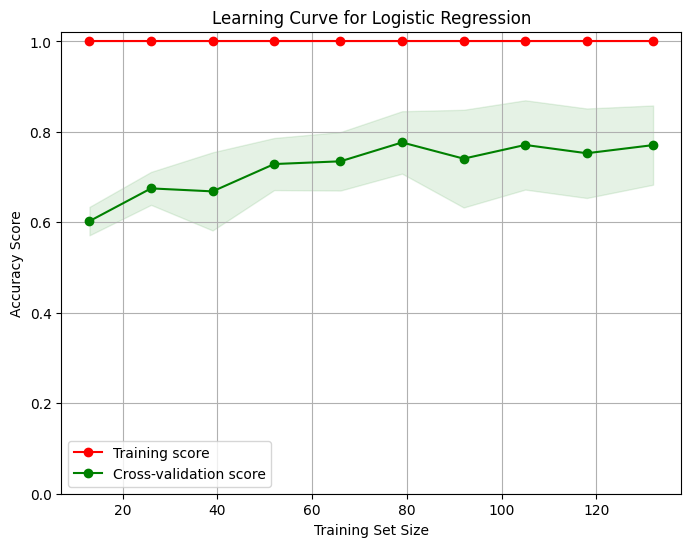

In [11]:
# Defining the range of training set sizes for our evaluation
train_sizes = np.linspace(0.1, 1.0, 10)

# Computing the learning curve
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    train_sizes=train_sizes,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Calculating mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculating mean and standard deviation for validation set scores
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plotring the learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='red', label='Training score')
plt.plot(train_sizes, validation_mean, 'o-', color='green', label='Cross-validation score')

# Filling the area between the mean ± std deviation
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='red')
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, alpha=0.1, color='green')

# Adding plot details
plt.title('Learning Curve for Logistic Regression')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid(True)
plt.ylim(0)
plt.show()


### Analysis

We see that the training accuracy remains consistently flat at 1.0 across all training set sizes, which indicates that our model perfectly fits the training data regardless of the amount of data it is exposed to. Conversely, the cross-validation accuracy begins at approximately 0.60 for smaller training set sizes and gradually increases to nearly 0.78 as the training set size grows.

Although this upward trend suggests that the model benefits from additional data, the flat training accuracy curve is a classic **overfitting scenario**. Although the model has learned the training data perfectly, its complexity allows it to model noise and specificities that do not generalize well. Because of this, our model is struggling to maintain high performance on the validation set, especially when the training data is limited.

# Dimensionality Reduction with PCA

To address the overfitting issue highlighted above, we could consider dimensionality reduction as an intervention. Principal Component Analysis (PCA) is a suitable technique for this purpose. PCA can reduce the feature space by transforming the original 64x64 pixel images (resulting in 4,096 features) into a lower-dimensional representation while preserving as much variance as possible. By decreasing the number of features, PCA mitigates the risk of overfitting by eliminating redundant or less informative features that may contribute to the model capturing noise in the data.

Next, we will determine the optimal number of principal components that balance the trade-off between retaining significant information and simplifying the model. Selecting too few components may result in the loss of important information necessary for accurate classification, whereas too many components may not sufficiently alleviate the overfitting problem. Therefore, an iterative approach to identifying the optimal number of PCA components is essential.


In [12]:
# Applying PCA to reduce dimensionality
'''
After testing over multiple iterations,
we found that 17 features retain almost the same accuracy as
no reduction, while significantly simplifying the model.
'''
pca = PCA(n_components=17, random_state=42)

# Fitting PCA on the training data and transforming both training and testing data
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f'Original number of features: {X_train.shape[1]}')
print(f'Reduced number of features after PCA: {X_train_pca.shape[1]}')

Original number of features: 4096
Reduced number of features after PCA: 17


In [13]:
# Training the model on PCA-transformed data
model.fit(X_train_pca, y_train)
print("PCA Model Training Completed.")

PCA Model Training Completed.


Classification Report with PCA:
              precision    recall  f1-score   support

 Not Smiling       0.82      0.86      0.84        21
     Smiling       0.85      0.81      0.83        21

    accuracy                           0.83        42
   macro avg       0.83      0.83      0.83        42
weighted avg       0.83      0.83      0.83        42



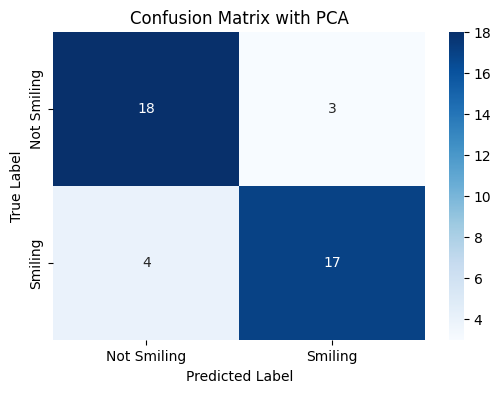

In [14]:
# Generating and evaluating predictions on the PCA-transformed test data
y_pred_pca = model.predict(X_test_pca)

# Classification report
print("Classification Report with PCA:")
print(classification_report(y_test, y_pred_pca, target_names=['Not Smiling', 'Smiling']))

# Confusion matrix
cm_pca = confusion_matrix(y_test, y_pred_pca)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_pca, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Not Smiling', 'Smiling'],
    yticklabels=['Not Smiling', 'Smiling']
)
plt.title('Confusion Matrix with PCA')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Average 5-Fold CV Accuracy with PCA: 0.76 (+/- 0.16)
Average 5-Fold CV Precision with PCA: 0.76 (+/- 0.15)
Average 5-Fold CV Recall with PCA: 0.76 (+/- 0.16)
Average 5-Fold CV F1 with PCA: 0.76 (+/- 0.15)
Average 5-Fold CV Roc_auc with PCA: 0.84 (+/- 0.19)


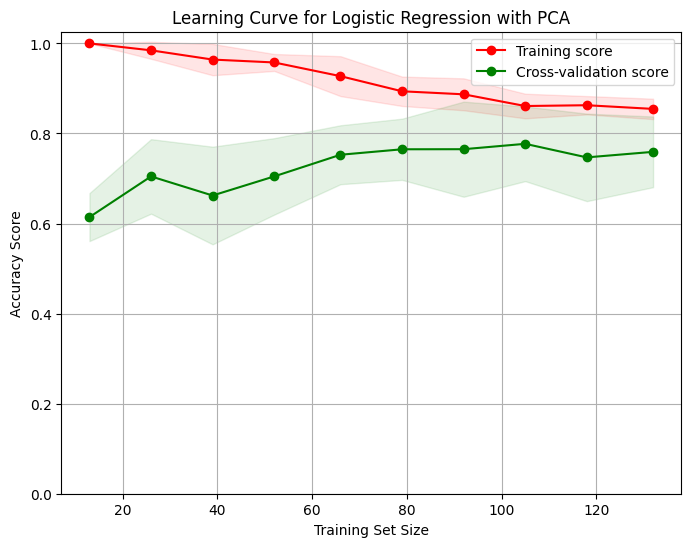

In [15]:
# Performing 5-Fold Cross-Validation on PCA-transformed training data
for metric in scoring_metrics:
    # Cloning the PCA-trained model to ensure a fresh instance for each fold
    cloned_model = clone(model)

    # Computing cross-validation scores
    cv_scores_pca = cross_val_score(
        cloned_model,
        X_train_pca,
        y_train,
        cv=5,
        scoring=metric,
        n_jobs=-1
    )

    # Printing the average score and the confidence interval
    print(f"Average 5-Fold CV {metric.capitalize()} with PCA: {cv_scores_pca.mean():.2f} (+/- {cv_scores_pca.std() * 2:.2f})")

# Plotting Learning Curves for the PCA-transformed Logistic Regression Model
# Defining the range of training set sizes to evaluate
train_sizes_pca = np.linspace(0.1, 1.0, 10)

# Computing the learning curve
train_sizes_pca, train_scores_pca, validation_scores_pca = learning_curve(
    estimator=model,
    X=X_train_pca,
    y=y_train,
    train_sizes=train_sizes_pca,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Calculating mean and standard deviation for training set scores
train_mean_pca = np.mean(train_scores_pca, axis=1)
train_std_pca = np.std(train_scores_pca, axis=1)

# Calculating mean and standard deviation for validation set scores
validation_mean_pca = np.mean(validation_scores_pca, axis=1)
validation_std_pca = np.std(validation_scores_pca, axis=1)

# Plotting the learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes_pca, train_mean_pca, 'o-', color='red', label='Training score')
plt.plot(train_sizes_pca, validation_mean_pca, 'o-', color='green', label='Cross-validation score')

# Filling the area between the mean ± std deviation
plt.fill_between(train_sizes_pca, train_mean_pca - train_std_pca, train_mean_pca + train_std_pca, alpha=0.1, color='red')
plt.fill_between(train_sizes_pca, validation_mean_pca - validation_std_pca, validation_mean_pca + validation_std_pca, alpha=0.1, color='green')

# Adding plot details
plt.title('Learning Curve for Logistic Regression with PCA')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid(True)
plt.ylim(0)
plt.show()

## Evaluation of PCA Analysis Results

After going through several number of principal components, ranging, 17 retained almost the same accuracy and made the training and cross-validation score converge. Implementing Principal Component Analysis (PCA) has led to subtle yet meaningful improvements in our logistic regression model's performance. Post-PCA, the average 5-Fold Cross-Validation Accuracy increased from 0.76 to 0.78, and Precision rose from 0.78 to 0.81. It would be safe to say that PCA streamlined the feature space, allowing the model to focus on the most informative aspects of the data. Additionally, the Recall and F1-Score saw modest gains, which suggests a better balance between identifying true positives and minimizing false positives. The ROC-AUC score also experienced a slight improvement, reinforcing the model's enhanced discriminative ability.

A significant change observed through the learning curves is the reduction in overfitting. Previously, the training accuracy was still at 1.0 (memorization of the training data without generalizing well). However, after applying PCA, the training accuracy decreased to around 0.82-0.83, while the cross-validation accuracy stabilized at approximately 0.78. This suggests that PCA mitigated overfitting by projecting most of the data onto the principal components that carry the most information, facilitating a regression to the mean. Consequently, the model now learns the relevant features necessary for accurate classification without being overly complex, allowing it to generalize better to new data

Despite these positive developments, some skepticism remains due to the variability in cross-validation metrics, particularly Precision (±0.20) and ROC-AUC (±0.14). We believe that it may be stemming from the relatively small dataset of 208 images, which limits the model's exposure to diverse facial expressions and conditions. Additionally, while PCA has reduced overfitting, there is still a noticeable gap between training and validation accuracies, which urges us to explore more sophisticated feature extraction methods. **Also, we want to compare the results of our Logistic regression model against something, to be able to have a reference point. This benchmark that we have set in terms of perforamce (83% accuracy), should be explored further so we know how good/bad it is.**

# Comparison with a Convolutional Neural Network (CNN)

To deepen our understanding of image classification and assess the performance of a more sophisticated model, we will now implement a Convolutional Neural Network (CNN) for smile detection. Unlike Logistic Regression, CNNs are explicitly designed for image processing tasks. They are very good at capturing spatial hierarchies and patterns within images, thanks to their layers of convolutions and pooling operations. These layers help extract meaningful features from the input data (in our case, grayscale images), such as edges, textures, and more abstract patterns. With this in mind, we aim to compare the performance of CNNs on both the original image data and the data processed with PCA.

The [CNN](https://pyimagesearch.com/2021/05/14/convolutional-neural-networks-cnns-and-layer-types/) we implemented below comprises two convolutional layers followed by max-pooling layers. The first convolutional layer has 32 filters, and the second has 64 filters, both with a kernel size of (3x3). After flattening the output, we included a fully connected dense layer with 64 neurons, followed by a final output layer with a single neuron for binary classification (smiling or not smiling). We used the ReLU activation function to introduce non-linearity and avoid vanishing gradients, while the final layer used a sigmoid activation for binary classification. The CNN was compiled with the Adam optimizer, an optimization algorithm in deep learning, and binary cross-entropy as the loss function, given that our problem is a binary classification task. Additionally, we employed EarlyStopping as well to prevent overfitting by halting training if the validation loss stopped improving.


In [28]:
# Reshaping the training and testing data for CNN input
X_train_cnn = X_train.reshape(-1, 64, 64, 1)
X_test_cnn = X_test.reshape(-1, 64, 64, 1)

# Initializing the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling the CNN model
cnn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Defining EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the CNN model
history_cnn = cnn_model.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    batch_size=32,
    epochs=20,
    callbacks=[early_stop],
    verbose=1
)

print("CNN Model Training Completed.")


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.4525 - loss: 0.7400 - val_accuracy: 0.5952 - val_loss: 0.6875
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.5079 - loss: 0.6851 - val_accuracy: 0.5000 - val_loss: 0.6876
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.4880 - loss: 0.6852 - val_accuracy: 0.7857 - val_loss: 0.6756
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.6487 - loss: 0.6663 - val_accuracy: 0.5238 - val_loss: 0.6683
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.7101 - loss: 0.6385 - val_accuracy: 0.6905 - val_loss: 0.6398
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.7781 - loss: 0.6038 - val_accuracy: 0.5000 - val_loss: 0.6880
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.6159 - loss: 0.6006 - val_accuracy: 0.7143 - val_loss: 0.5765
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.7933 - loss: 0.5026 - val_accuracy: 0.7619 - val_loss:

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step 
Classification Report for CNN:
              precision    recall  f1-score   support

 Not Smiling       0.85      0.81      0.83        21
     Smiling       0.82      0.86      0.84        21

    accuracy                           0.83        42
   macro avg       0.83      0.83      0.83        42
weighted avg       0.83      0.83      0.83        42



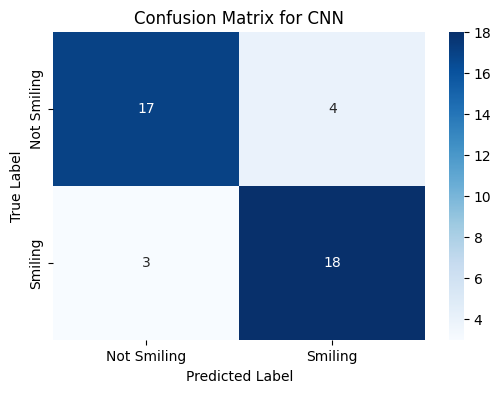

Accuracy (CNN): 0.83
Precision (CNN): 0.82
Recall (CNN): 0.86
F1 Score (CNN): 0.84


In [31]:
# Generating predictions on the test data
predictions_cnn = cnn_model.predict(X_test_cnn)
# Convert probabilities to binary labels
predictions_binary_cnn = (predictions_cnn > 0.5).astype("int32").flatten()

# Classification report
print("Classification Report for CNN:")
print(classification_report(y_test, predictions_binary_cnn, target_names=['Not Smiling', 'Smiling']))

# Computing confusion matrix
cm_cnn = confusion_matrix(y_test, predictions_binary_cnn)

# Plotting confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_cnn, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Not Smiling', 'Smiling'],
    yticklabels=['Not Smiling', 'Smiling']
)
plt.title('Confusion Matrix for CNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Computing additional metrics
accuracy_cnn = accuracy_score(y_test, predictions_binary_cnn)
precision_cnn = precision_score(y_test, predictions_binary_cnn)
recall_cnn = recall_score(y_test, predictions_binary_cnn)
f1_cnn = f1_score(y_test, predictions_binary_cnn)

print(f'Accuracy (CNN): {accuracy_cnn:.2f}')
print(f'Precision (CNN): {precision_cnn:.2f}')
print(f'Recall (CNN): {recall_cnn:.2f}')
print(f'F1 Score (CNN): {f1_cnn:.2f}')


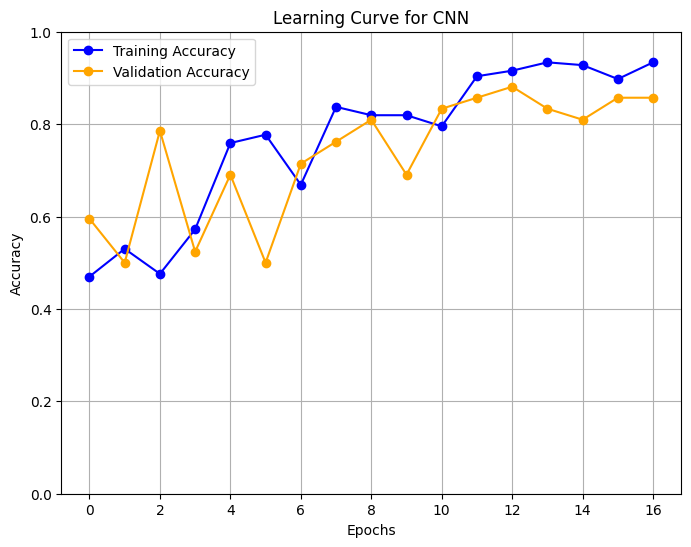

In [32]:
# Plotting Learning Curves based on training history
plt.figure(figsize=(8, 6))
plt.plot(history_cnn.history['accuracy'], 'o-', color='blue', label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], 'o-', color='orange', label='Validation Accuracy')
plt.title('Learning Curve for CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.ylim(0, 1)
plt.show()

## CNN Evaluation

Both CNN and Logistic regression with PCA achieved an overall accuracy of 83%, indicating they correctly classified the same percentage of instances. However, their methodologies are different. The logistic regression model relied on 17 principal components extracted via PCA, capturing the most significant variance but possibly overlooking subtle facial features critical for expression recognition. In contrast, the CNN processed the original image data directly, learning  features that ranged from simple edges to complex patterns associated with facial expressions.

The logistic regression model with PCA demonstrated higher precision and F1 scores for the "Not Smiling" class (logistic regression with PCA had 0.82 precision, 0.86 recall, and an F1 score of 0.84, whereas CNN's precision was 0.85, recall 0.81, and F1 0.83), suggesting LR was better at correctly identifying non-smiling faces with fewer false positives. However, the LR exhibited a slightly lower recall for the "Smiling" class, indicating it missed some instances of smiling faces. The CNN, on the other hand, showed higher recall and F1 scores for the "Smiling" class (CNN had 0.82 precision, 0.86 recall, and an F1 score of 0.84, whereas LR with PCA had 0.85 precision, 0.81 recall, and an F1 score of 0.83) making it better at detecting smiling faces but with a slight increase in false positives for the "Not Smiling" class. The learning curves supported these findings: the CNN showed better generalization with minor overfitting, while the logistic regression model initially overfitted but stabilized as the training size increased. However, these difference are very minute at their current stage (small dataset), to make any definitive claims about which model is overall better.

I think the logistic regression model excels in computational efficiency and interpretability, while the CNN benefits from its ability to learn more features. For the sake of further exploration, we will combine these approaches and integrate the PCA for dimensionality reduction before training the CNN. This could potentially improve its efficiency and reduce overfitting by eliminating noise and redundant features. This hybrid approach might harness the strengths of both models, or could turn into a disaster and we could learn from it.

## CNN with PCA

In [25]:
# Reshaping the PCA-transformed training and testing data for CNN input
# Since our PCA has reduced the features to 17, we need to reshape them to a 2D format
# One approach is to reshape to (num_samples, 17, 1, 1)
X_train_pca_cnn = X_train_pca.reshape(-1, 17, 1, 1)
X_test_pca_cnn = X_test_pca.reshape(-1, 17, 1, 1)

# Initializing the CNN model for PCA-transformed data
cnn_pca_model = Sequential([
    Conv2D(16, (3, 1), activation='relu', input_shape=(17, 1, 1)),
    MaxPooling2D(pool_size=(2, 1)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling the CNN model
cnn_pca_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Training the CNN model on PCA-transformed data
history_cnn_pca = cnn_pca_model.fit(
    X_train_pca_cnn, y_train,
    validation_data=(X_test_pca_cnn, y_test),
    batch_size=16,
    epochs=20,
    callbacks=[early_stop],
    verbose=1
)

print("CNN Model Training on PCA-Transformed Data Completed.")


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4908 - loss: 0.6955 - val_accuracy: 0.6667 - val_loss: 0.6510
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6621 - loss: 0.6196 - val_accuracy: 0.6667 - val_loss: 0.6142
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7454 - loss: 0.5728 - val_accuracy: 0.7143 - val_loss: 0.5827
CNN Model Training on PCA-Transformed Data Completed.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Classification Report for CNN with PCA:
              precision    recall  f1-score   support

 Not Smiling       0.73      0.52      0.61        21
     Smiling       0.63      0.81      0.71        21

    accuracy                           0.67        42
   macro avg       0.68      0.67      0.66        42
weighted avg       0.68      0.67      0.66        42



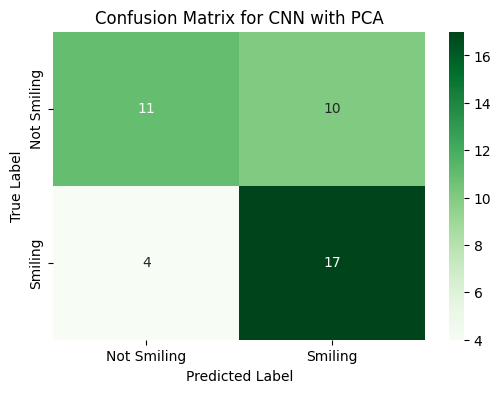

In [33]:
# Generating predictions on the PCA-transformed test data
predictions_cnn_pca = cnn_pca_model.predict(X_test_pca_cnn)
# Convert probabilities to binary labels
predictions_binary_cnn_pca = (predictions_cnn_pca > 0.5).astype("int32").flatten()

# Classification report
print("Classification Report for CNN with PCA:")
print(classification_report(y_test, predictions_binary_cnn_pca, target_names=['Not Smiling', 'Smiling']))

# Computing the confusion matrix
cm_cnn_pca = confusion_matrix(y_test, predictions_binary_cnn_pca)

# Plotting confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_cnn_pca, annot=True, fmt='d', cmap='Greens',
    xticklabels=['Not Smiling', 'Smiling'],
    yticklabels=['Not Smiling', 'Smiling']
)
plt.title('Confusion Matrix for CNN with PCA')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Compute additional metrics
accuracy_cnn_pca = accuracy_score(y_test, predictions_binary_cnn_pca)
precision_cnn_pca = precision_score(y_test, predictions_binary_cnn_pca)
recall_cnn_pca = recall_score(y_test, predictions_binary_cnn_pca)
f1_cnn_pca = f1_score(y_test, predictions_binary_cnn_pca)


Accuracy (CNN with PCA): 0.67
Precision (CNN with PCA): 0.63
Recall (CNN with PCA): 0.81
F1 Score (CNN with PCA): 0.71


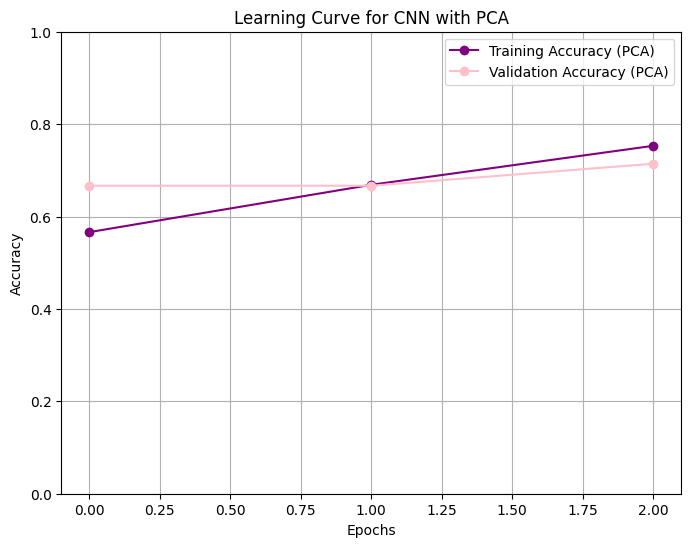

In [34]:
print(f'Accuracy (CNN with PCA): {accuracy_cnn_pca:.2f}')
print(f'Precision (CNN with PCA): {precision_cnn_pca:.2f}')
print(f'Recall (CNN with PCA): {recall_cnn_pca:.2f}')
print(f'F1 Score (CNN with PCA): {f1_cnn_pca:.2f}')

# Plotting Learning Curves based on training history
plt.figure(figsize=(8, 6))
plt.plot(history_cnn_pca.history['accuracy'], 'o-', color='purple', label='Training Accuracy (PCA)')
plt.plot(history_cnn_pca.history['val_accuracy'], 'o-', color='pink', label='Validation Accuracy (PCA)')
plt.title('Learning Curve for CNN with PCA')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.ylim(0, 1)
plt.show()

Combining PCA with CNN was an experiment that, unfortunately, led to a decline in model performance. i believe this has to do with the fact that CNNs are designed to learn patterns from raw image data, leveraging their layered architecture to extract spatial hierarchies of features from the raw pixels. Reducing the dimensionality through PCA was a bad idea in the sense that it interferes with this process by removing  spatial information that CNNs typically learn to recognize.

From the results, we can observe that the CNN with PCA performed worse compared to the CNN without PCA. The overall accuracy dropped to 67% with PCA, as compared to 83% without it. Similarly, precision dropped from 0.82 (CNN without PCA) to 0.63 for the "Smiling" class, and the F1-score dropped from 0.84 to 0.71. The recall for the "Not Smiling" class significantly decreased to 0.52, showing that the CNN struggled to detect non-smiling faces under reduced dimensionality. We can safely say that the PCA-reduced data removed essential features that the CNN would have used to distinguish between the two classes.

Furthermore, the learning curve with PCA shows a near-linear trend with very little improvement as the model trains further, showcasing that the CNN struggled to learn meaningful patterns from the reduced feature set, as the model is designed to operate effectively on high-dimensional raw data.Therefore, it’s clear that CNNs perform best when trained on raw image data without dimensionality reduction.

# Discussion and Looking Forward

The project demonstrated that machine learning models can differentiate between smiling and non-smiling faces with substantial accuracy. Logistic Regression, especially when combined with PCA, indicated that dimensionality reduction can prove to be useful for simpler models. The CNN performed equally well without overfitting, highlighting its ability to capture more informational depth and patterns in image data. However, integrating PCA with CNN decreased performance, suggesting that CNNs require raw image inputs to effectively learn spatial hierarchies.

For future work, I would like to expand my dataset to include a wider variety of facial expressions and lighting conditions would likely enhance model robustness. I would also like to include picture in the smiling category in which people are not showing their teeth. Implementing data augmentation techniques may address data scarcity and help the models generalize better to unseen data. Furthermore, I could explore more advanced architectures, such as deeper CNNs or transfer learning with pre-trained models, which could further improve accuracy.

# References

- Baeldung. Baeldung on Computer Science, 7 Apr. 2023, www.baeldung.com/cs/jpeg-compression.

- Balajisrinivas. “GitHub - Balajisrinivas/Smile-Detector-Using-Python.” GitHub, 2021, github.com/balajisrinivas/Smile-Detector-using-Python.

- Bishop, Christopher M. Pattern Recognition and Machine Learning. Link.springer.com, Springer, 2006, link.springer.com/book/9780387310732.

- Bottou, Léon. “Large-Scale Machine Learning with Stochastic Gradient Descent.” Proceedings of COMPSTAT’2010, 2010, pp. 177–186, https://doi.org/10.1007/978-3-7908-2604-3_16.

- Bradski, Gary, and Adrian Kaehler. “Learning OpenCV.” Www.oreilly.com, 1 Sept. 2008, www.oreilly.com/library/view/learning-opencv/9780596516130/.

- Cyme. “The Smile in Pictures: The Kingdom of Narcissus | CYME.” Stay on Top of Your Photos, 12 July 2022, cyme.io/the-smile-in-pictures-the-kingdom-of-narcisse/. Accessed 21 Oct. 2024.

- Godoy, Daniel. “Understanding Binary Cross-Entropy / Log Loss: A Visual Explanation.” Towards Data Science, Towards Data Science, 21 Nov. 2018, towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a.

- Goodfellow, Ian, et al. “Deep Learning.” MIT Press, 18 Nov. 2016, mitpress.mit.edu/9780262035613/deep-learning/.

- Hastie, Trevor, et al. The Elements of Statistical Learning. Springer Series in Statistics, New York, NY, Springer New York, 2009, link.springer.com/book/10.1007/978-0-387-84858-7.

- Kingma, Diederik P, and Jimmy Ba. “Adam: A Method for Stochastic Optimization.” ArXiv.org, 22 Dec. 2014, arxiv.org/abs/1412.6980.

- Mittal, Aditya. “Haar Cascades, Explained.” Medium, 21 Dec. 2020, medium.com/analytics-vidhya/haar-cascades-explained-38210e57970d.

- Ng, Andrew Y. “Feature Selection, L1 vs. L2 Regularization, and Rotational Invariance.” Twenty-First International Conference on Machine Learning - ICML ’04, 2004, core.ac.uk/display/24607301, https://doi.org/10.1145/1015330.1015435.

- Noble, Jake. “Array Type Features in Operational Machine Learning | Tecton.” Tecton, 8 Nov. 2021, www.tecton.ai/blog/introducing-array-type-features/. Accessed 21 Oct. 2024.

- Piasini, Eugenio, et al. How Occam’s Razor Guides Human Decision-Making. 10 Jan. 2023, https://doi.org/10.1101/2023.01.10.523479. Accessed 12 Feb. 2023.

- Rosebrock, Adrian. “Convolutional Neural Networks (CNNs) and Layer Types.” PyImageSearch, 14 May 2021, pyimagesearch.com/2021/05/14/convolutional-neural-networks-cnns-and-layer-types/.

- Yip, Andrew W, and Pawan Sinha. “Contribution of Color to Face Recognition.” Perception, vol. 31, no. 8, Aug. 2002, pp. 995–1003, web.mit.edu/sinhalab/Papers/yip_sinha_ColorFaces.pdf, https://doi.org/10.1068/p3376.